# See dropout effect on Sparsity with cifar10

From Hinton's paper
- https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

>We found that as a side-effect of doing dropout, the activations of the hidden units
become sparse, even when no sparsity inducing regularizers are present.

So I reproduced this side-effect by
1. Create CNN with and without dropout
2. Compare their activation behavior

# Setup

### Load image data

In [108]:
from keras.datasets import cifar10
(trainX, trainy), (testX, testy) = cifar10.load_data()

# Scale down pixcel value range to from [0,255] to [0,1]
trainX = trainX.astype("float32")
testX = testX.astype("float32")
trainX /= 255
testX  /= 255

# Change format of y to 1-hot vector
from keras.utils import np_utils
trainY = np_utils.to_categorical(trainy, 10)
testY = np_utils.to_categorical(testy, 10)

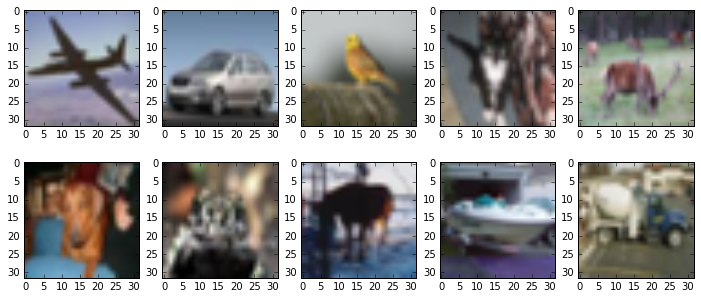

In [76]:
import random

def fetch_sample_input_for_all_class(class_num, X, y):
    def fetch_sample_input_of_class(i):
        all_target_class_data = [x for x, cls in zip(X, y) if cls == i]
        return random.sample(all_target_class_data, 1)[0]
    return [fetch_sample_input_of_class(i) for i in range(class_num)]

plt.figure(figsize=(12, 5))
for cls, data in enumerate(fetch_sample_input_for_all_class(10, testX, testy), start=1):
    plt.subplot(2, 5, cls)
    r, g, b = data
    rgb = np.dstack((r,g,b))
    plt.imshow(rgb)
plt.show()

# Create models

### Prepare function to evaluate trained model

In [242]:
import numpy as np
from sklearn.metrics import classification_report

def evaluate_model(model, testX, testY):
    Yhat = model.predict(testX)
    yhat = np.argmax(Yhat, axis=1)
    print(classification_report(testy, yhat))

## 1. Create model without Dropout

### Define model architecture

In [253]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten

model = Sequential()
# Alternating convolutions and nonlinearities
model.add(Convolution2D(32, 3, 3, border_mode="same", input_shape=(3, 32, 32)))
model.add(Activation("relu"))
model.add(Convolution2D(32, 3, 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(32, 3, 3, border_mode="same"))
model.add(Activation("relu"))
model.add(Convolution2D(64, 3, 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# fully connected layers from here and connected to softmax layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

### Start training for 200 epoch
- overfitting...

In [241]:
model.fit(trainX, trainY, batch_size=128, nb_epoch=200, validation_split=0.1, verbose=1)

<img src="loss_history.png" width=500/>

### Evaluate model prediction accuracy

In [244]:
model.load_weights("cifar10_cnn_weight.h5")
evaluate_model(model, testX, testY)

             precision    recall  f1-score   support

          0       0.67      0.72      0.69      1000
          1       0.76      0.74      0.75      1000
          2       0.57      0.53      0.55      1000
          3       0.44      0.43      0.43      1000
          4       0.55      0.56      0.56      1000
          5       0.53      0.52      0.53      1000
          6       0.70      0.73      0.72      1000
          7       0.68      0.69      0.68      1000
          8       0.74      0.73      0.73      1000
          9       0.69      0.68      0.69      1000

avg / total       0.63      0.63      0.63     10000



## 2. Create model with Dropout

### Define model architecture

In [268]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten, Dropout

model = Sequential()
# Alternating convolutions and nonlinearities
model.add(Convolution2D(32, 3, 3, border_mode="same", input_shape=(3, 32, 32)))
model.add(Activation("relu"))
model.add(Convolution2D(32, 3, 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(32, 3, 3, border_mode="same"))
model.add(Activation("relu"))
model.add(Convolution2D(64, 3, 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# fully connected layers from here and connected to softmax layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

### Start training for 200 epoch
- Not overfitting !!

In [ ]:
model.fit(trainX, trainY, batch_size=128, nb_epoch=200, validation_split=0.1, verbose=0)

<img src="with_dropout_loss_history.png" width=500/>

### Evaluate model prediction accuracy

In [246]:
model.load_weights("cifar10_cnn_with_dropout_weight.h5")
evaluate_model(model, testX, testY)

             precision    recall  f1-score   support

          0       0.83      0.80      0.82      1000
          1       0.89      0.89      0.89      1000
          2       0.76      0.67      0.71      1000
          3       0.66      0.60      0.63      1000
          4       0.76      0.78      0.77      1000
          5       0.68      0.74      0.71      1000
          6       0.80      0.88      0.84      1000
          7       0.83      0.85      0.84      1000
          8       0.87      0.88      0.87      1000
          9       0.86      0.87      0.87      1000

avg / total       0.79      0.79      0.79     10000



# See dropout effect on sparcity 

## Prepare helper function

### Helper function to visualize how output layer is activated

In [271]:
%matplotlib inline
from keras import backend as K

def record_activation(model):
    cnv1, sftmx = model.layers[0], model.layers[-1]
    sftmx_output = K.function(model.inputs, [sftmx.output])
    record = [[[None for k in range(32)] for j in range(32)] for i in range(3)]
    for i in range(3):
        for j in range(32):
            for k in range(32):
                X = [np.zeros((32, 32)) for _ in range(3)]
                X[i][j][k] = 1
                record[i][j][k] = sftmx_output([[X]])[0]
    return record

def record_activation_dropout(model):
    sftmx = model.layers[-1]
    inputs = [K.learning_phase()] + model.inputs
    sftmx_output = K.function(inputs, [sftmx.output])
    record = [[[None for k in range(32)] for j in range(32)] for i in range(3)]
    for i in range(3):
        for j in range(32):
            for k in range(32):
                X = [np.zeros((32, 32)) for _ in range(3)]
                X[i][j][k] = 1
                record[i][j][k] = sftmx_output([0, [X]])[0]
    return record
            

def plot_activation(record):
    ndrecord = np.array(record).reshape(3*32*32, 10)
    plt.figure(figsize=(6,15))
    for i, rec in enumerate(ndrecord.T):
        rgb = rec.reshape(3, 32, 32)
        for j, activate_data in enumerate(rgb):
            plt.subplot(10, 3, i*3 + j + 1)
            plt.imshow(rgb[j], cmap="gray")
    plt.show()

### Helper functions to generate histgram of activation behavior

In [251]:
def fetch_activation_layers(model):
    return [layer for layer in model.layers if type(layer) == Activation]
    
def flow_input_through_layer(model, layer, X):
    inputs = [K.learning_phase()] + model.inputs
    layer_func = K.function(inputs, [layer.output])
    return layer_func([0, [X]])[0]

def flow_input_through_model(model, X):
    curry = lambda layer: flow_input_through_layer(model, layer, X)
    return reduce(lambda acc, layer: acc + [curry(layer)], fetch_activation_layers(model), [])

def summary_output_of_layer(layer, out):
    name = layer.name
    mean_activation = out.mean()
    elem_num = reduce(lambda acc, e: acc * e, out.shape, 1)
    zero_num = elem_num - np.count_nonzero(out)
    return name, mean_activation, elem_num, zero_num

def summary_output_of_model(model, output_holder):
    return reduce(lambda acc, arg: acc + [summary_output_of_layer(*arg)],
                  zip( fetch_activation_layers(model), output_holder), [])

def take_statistics(model, targetX):
    flow_c = lambda X: flow_input_through_model(model, X)
    fetch_c = lambda holder: summary_output_of_model(model, holder)
    return np.array(map(fetch_c, map(flow_c, targetX)))

def gen_mean_activation_hist(means):
    m = means.astype(np.float).reshape(means.size)
    plt.hist(m, bins=np.arange(m.min(), m.max(), (m.max()-m.min())/50))
    plt.title("mean activation")
    plt.xlabel("mean activation of layer")
    plt.ylabel("frequency")
    plt.show()

def gen_zero_num_hist(zero_counts):
    z = zero_counts.astype(np.int)
    plt.hist(z.T.sum(1), bins=50)
    plt.title("zero activation count on a data")
    plt.xlabel("zero activation count")
    plt.ylabel("frequency")
    plt.show()
    
def gen_hist_from_statistics(statistics):
    names, means, elem_nums, zero_nums = statistics.T
    gen_mean_activation_hist(means)
    gen_zero_num_hist(zero_nums)

## Visualize activation of output layer

### 1. Without Dropout

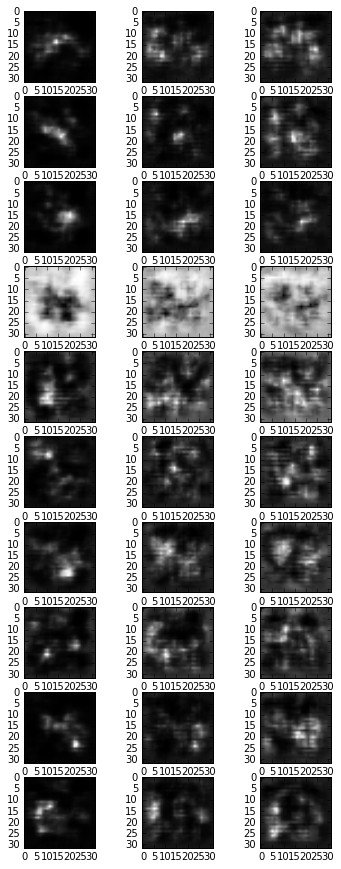

In [265]:
model.load_weights("cifar10_cnn_weight.h5")
record = record_activation(model)
plot_activation(record)

### 2. With Dropout

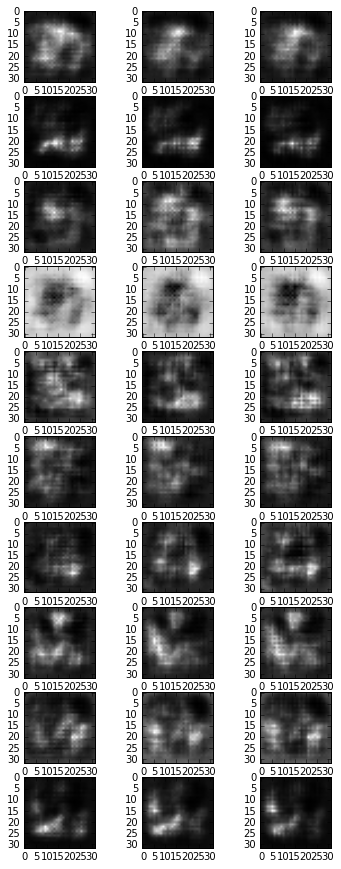

In [273]:
model.load_weights("cifar10_cnn_with_dropout_weight.h5")
record = record_activation_dropout(model)
plot_activation(record)

## Compare activation histgrams

### 1. Without Dropout

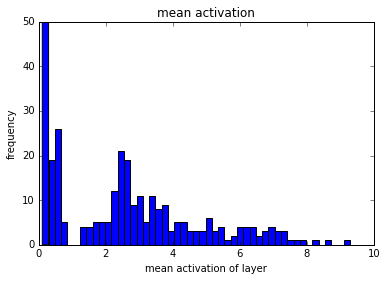

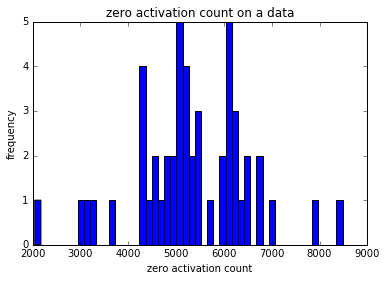

In [238]:
statistics = take_statistics(model, trainX[:50])
gen_hist_from_statistics(statistics)

### 2. With Dropout

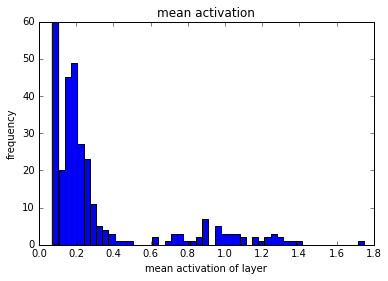

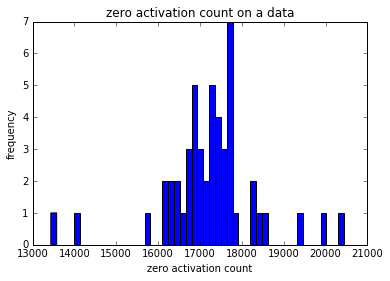

In [274]:
statistics = take_statistics(model, trainX[:50])
gen_hist_from_statistics(statistics)